In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import copy as cp
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score, cross_val_predict 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve
from sklearn.metrics import confusion_matrix, accuracy_score

from typing import Tuple

In [2]:
pd.set_option("display.max_columns", 200)
pd.set_option("display.max_row", 160)
pd.set_option('max_colwidth', 200)

In [3]:
data = pd.read_csv('../../Data/20x44_D10.csv')
data.head(5)

,loan_amnt,annual_inc,dti,fico_range_low,fico_range_high,int_rate,installment,open_acc,total_acc,revol_bal,inq_last_6mths,delinq_2yrs,acc_now_delinq,collections_12_mths_ex_med,tot_coll_amt,tot_cur_bal,pub_rec,months_cr_line,term,initial_list_status,grade,sub_grade,emp_length,ANY,MORTGAGE,OWN,RENT,car,credit_card,debt_consolidation,home_improvement,house,major_purchase,medical,moving,other,renewable_energy,small_business,vacation,wedding,Not Verified,Source Verified,Verified,loan_status_bin
0,-0.396712,-0.227411,-1.632665,-0.042835,-0.042835,1.330221,-0.368315,-1.357400,-1.429763,-0.446509,0.060269,-0.384455,-0.046594,-0.144244,-0.123362,-0.755915,-0.380505,-0.891191,-0.073791,-1.088672,0.0,0.699795,-0.944160,-0.023278,-0.704954,2.481326,-1.057140,-0.15163,-0.324588,-0.934194,-0.251077,-0.111065,-0.175216,-0.188717,-0.187946,1.989233,-0.043578,-0.125206,-0.15441,-0.063862,-0.611460,1.355140,-0.775100,1.0
1,-0.225330,0.075280,1.085593,-0.786668,-0.786668,-0.684651,-0.235771,-0.021498,-0.756386,-0.083143,-0.874914,-0.384455,-0.046594,-0.144244,-0.029451,-0.471814,1.411848,-1.416929,-0.073791,0.918550,0.0,-1.428989,1.289366,-0.023278,-0.704954,-0.403010,0.945948,-0.15163,-0.324588,-0.934194,-0.251077,-0.111065,-0.175216,-0.188717,5.320669,-0.502706,-0.043578,-0.125206,-0.15441,-0.063862,-0.611460,-0.737931,1.290156,0.0
2,-1.639232,0.093625,-0.671452,-0.538724,-0.538724,-0.684651,-1.638581,-0.594027,0.085335,-0.029596,-0.874914,-0.384455,-0.046594,-0.144244,-0.123362,-0.554828,-0.380505,0.037241,-0.073791,0.918550,0.0,-1.428989,0.296688,-0.023278,-0.704954,-0.403010,0.945948,-0.15163,-0.324588,-0.934194,-0.251077,-0.111065,-0.175216,-0.188717,-0.187946,1.989233,-0.043578,-0.125206,-0.15441,-0.063862,1.635429,-0.737931,-0.775100,0.0
3,-0.353867,-0.126138,1.405257,-0.290779,-0.290779,1.330221,-0.324968,0.932719,-0.167182,-0.166618,-0.874914,-0.384455,-0.046594,-0.144244,-0.123362,-0.491176,-0.380505,-0.768145,-0.073791,-1.088672,0.0,0.699795,0.048518,-0.023278,-0.704954,-0.403010,0.945948,-0.15163,-0.324588,1.070442,-0.251077,-0.111065,-0.175216,-0.188717,-0.187946,-0.502706,-0.043578,-0.125206,-0.15441,-0.063862,-0.611460,1.355140,-0.775100,1.0
4,-0.139639,-0.135686,-0.067641,0.700999,0.700999,-0.684651,-0.150783,-0.212341,0.169507,-0.501057,-0.874914,-0.384455,-0.046594,-0.144244,3.508371,-0.469979,-0.380505,2.173752,-0.073791,0.918550,0.0,-1.428989,0.296688,-0.023278,-0.704954,-0.403010,0.945948,-0.15163,-0.324588,1.070442,-0.251077,-0.111065,-0.175216,-0.188717,-0.187946,-0.502706,-0.043578,-0.125206,-0.15441,-0.063862,1.635429,-0.737931,-0.775100,1.0


In [4]:
data.shape

(3693, 44)

In [5]:
data.loan_status_bin.value_counts()
#0 = Defaulted Loans
#1 = Loans Paid In Full

1.0    2750
0.0     943
Name: loan_status_bin, dtype: int64

In [6]:
X = data.drop('loan_status_bin', axis=1)
X.shape

(3693, 43)

In [7]:
y = data['loan_status_bin']

In [8]:
lr1 = LogisticRegression()

In [9]:
steps = [('model', lr1)]
pipeline = Pipeline(steps=steps)

In [10]:
#Accuracy:

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)
scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1) 
print(scores)

score = np.mean(scores)
print(score)

[0.74289581 0.74289581 0.74154263 0.7398374  0.74525745]
0.7424858172803649


In [11]:
#Aggregated Confusion Matrix From RepeatedStratifiedKFold: 
y_pred = cross_val_predict(pipeline, X, y, cv=cv, n_jobs=-1)
conf_mat = confusion_matrix(y, y_pred)
conf_mat

array([[  29,  914],
       [  37, 2713]])

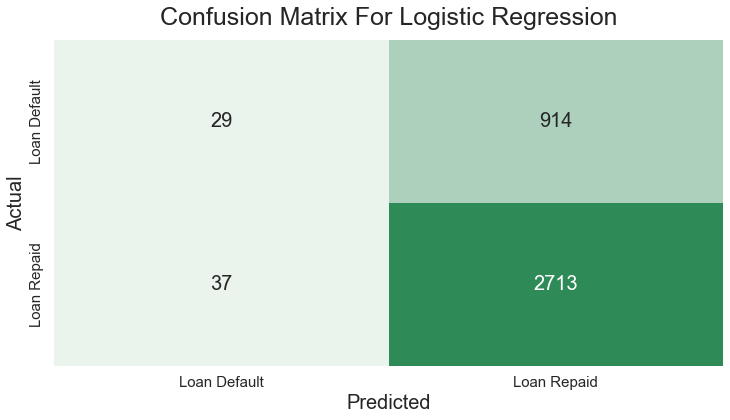

In [12]:
sns.set(rc = {'figure.figsize':(12,6)})
#cmap = sns.cubehelix_palette(start=2, rot=0, dark=0, light=.95, reverse=True, as_cmap=True)
cmap = sns.light_palette('seagreen', as_cmap=True)

res = sns.heatmap(conf_mat, annot=True, fmt='d', annot_kws={"size":20},
#            xticklabels = ['Good = Paid In Full', 'Bad = Default'],
#            yticklabels = ['Loan Paid In Full', 'Bad = Default'], 
            cmap=cmap, cbar=False)

res.set_xticklabels(['Loan Default', 'Loan Repaid'], fontsize=15)
res.set_yticklabels(['Loan Default', 'Loan Repaid'], fontsize=15)


plt.title('Confusion Matrix For Logistic Regression', fontsize=25, pad=15)
plt.xlabel('Predicted', fontsize=20)
plt.ylabel('Actual', fontsize=20);

In [13]:
accuracy_score(y, y_pred)

0.7424857839155159

In [14]:
TN, FP, FN, TP = conf_mat.ravel()
print(TP)
print(FP)
print(FN)
print(TN)
print((TP + TN) / (TN + TP + FP + FN))

2713
914
37
29
0.7424857839155159


In [15]:
#Re-examine original pool of accepted LC Loans: 

print(data.loan_status_bin.value_counts())
#0 = Loan Defaulted
#1 = Loan Fully Paid

good_loan = data.loan_status_bin.value_counts()[1]
bad_loan = data.loan_status_bin.value_counts()[0]

print()
print(good_loan / (good_loan + bad_loan))

#Random investment would give us 59% chance of pickkng a good loan

1.0    2750
0.0     943
Name: loan_status_bin, dtype: int64

0.7446520444083401


In [16]:
#Positive Predictive Value (or Precision)
#Logistic Model only does 3% better than Null Model or "random investment"
TP / (TP+FP)

0.7480011028398125

In [17]:
#Obtain predicted probabilities (not predicted classes) from RSKF: 
y_pred_prob = cross_val_predict(pipeline, X, y, cv=cv, n_jobs=-1, method='predict_proba')

In [18]:
y_pred_prob

array([[0.28417744, 0.71582256],
       [0.23973307, 0.76026693],
       [0.11661262, 0.88338738],
       ...,
       [0.2603284 , 0.7396716 ],
       [0.30847738, 0.69152262],
       [0.21725831, 0.78274169]])

In [19]:
#Obtaining classification based on desired threshold of 0.8: 

y_pred_success = (y_pred_prob[:, 1] > 0.8).astype('float')
y_pred_success

array([0., 0., 1., ..., 0., 0., 0.])

In [20]:
conf_mat = confusion_matrix(y, y_pred_success)
conf_mat

array([[ 751,  192],
       [1716, 1034]])

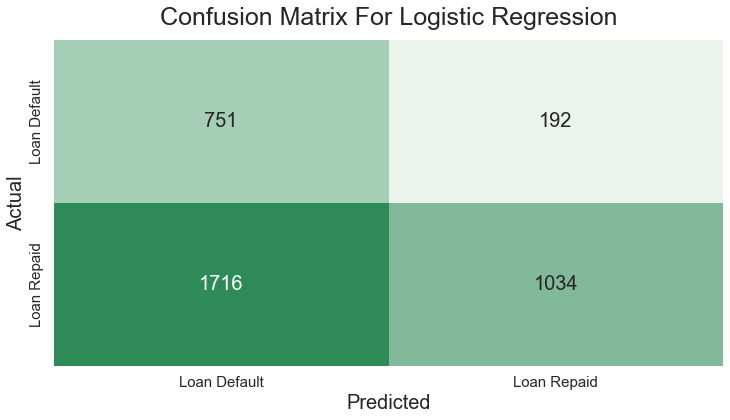

In [21]:
sns.set(rc = {'figure.figsize':(12,6)})
#cmap = sns.cubehelix_palette(start=2, rot=0, dark=0, light=.95, reverse=True, as_cmap=True)
cmap = sns.light_palette('seagreen', as_cmap=True)

res = sns.heatmap(conf_mat, annot=True, fmt='d', annot_kws={"size":20},
#            xticklabels = ['Good = Paid In Full', 'Bad = Default'],
#            yticklabels = ['Loan Paid In Full', 'Bad = Default'], 
            cmap=cmap, cbar=False)

res.set_xticklabels(['Loan Default', 'Loan Repaid'], fontsize=15)
res.set_yticklabels(['Loan Default', 'Loan Repaid'], fontsize=15)


plt.title('Confusion Matrix For Logistic Regression', fontsize=25, pad=15)
plt.xlabel('Predicted', fontsize=20)
plt.ylabel('Actual', fontsize=20);

In [22]:
accuracy_score(y, y_pred_success)

0.4833468724614135

In [23]:
TN, FP, FN, TP = conf_mat.ravel()
print(TP)
print(FP)
print(FN)
print(TN)
print((TP + TN) / (TN + TP + FP + FN))

1034
192
1716
751
0.4833468724614135


In [24]:
#Positive Predictive Value (or Precision)
#Logistic Model only does 3% better than Null Model or "random investment"
TP / (TP+FP)

0.8433931484502447

In [ ]:
## Next question. what was characteristic of the 217 loans that defaulted??
## Get all loans which you predicted greater than 80% and find out which ones defaulted.
## Any pattern?????

In [ ]:
#Do we drop all observations where the source is not verified? 
#Do we drop all observations loan amount is greater than half of one's income? 